In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
import torch
from torch_geometric.data import Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving finall_data.csv to finall_data.csv


In [ ]:
# uploaded = files.upload()

In [ ]:
df_filled = pd.read_csv('finall_data.csv')

In [ ]:
df_filled

,Environment and Agriculture,Communication,Consulting,Education,Energy,Entertainment,Finance,Government Administration,Healthcare,Hospitality,...,windows,wireless,word,xml,Seniority_Associate,Seniority_Director,Seniority_Entry level,Seniority_Executive,Seniority_Internship,Seniority_Mid-Senior level
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30241,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
30242,0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
30243,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
30244,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
df_filled = df_filled.drop(['post-pandemic'], axis = 1)

In [ ]:
df_filled.columns[:50]

Index(['Environment and Agriculture', 'Communication', 'Consulting',
       'Education', 'Energy', 'Entertainment', 'Finance',
       'Government Administration', 'Healthcare', 'Hospitality',
       'Human Resource', 'Information Technology', 'Legal Services',
       'Manufacturing', 'Real Estate', 'Remote', 'Retail', 'Social Service',
       'Transportation', 'CitySize_big', 'CitySize_medium', 'CitySize_rural',
       'CitySize_small', 'State_AL', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_FL', 'State_GA', 'State_IA', 'State_IL',
       'State_IN', 'State_KY', 'State_MA', 'State_MD', 'State_ME', 'State_MI',
       'State_MN', 'State_MO', 'State_NC', 'State_NE', 'State_NJ', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA'],
      dtype='object')

In [ ]:
df_filled = df_filled * 1
df_filled = df_filled.fillna(0)
df_filled = df_filled.apply(pd.to_numeric, errors='coerce')

In [ ]:
level = ['Seniority_Associate','Seniority_Director','Seniority_Entry level','Seniority_Executive','Seniority_Internship','Seniority_Mid-Senior level']

In [ ]:
df = df_filled.drop(['Remote'], axis = 1)
node_features = torch.tensor(df.values, dtype=torch.float)

edges = []
seniority_features = df_filled[level].values

for i in range(len(seniority_features)):
    for j in range(i + 1, len(seniority_features)):
        if np.any(seniority_features[i] & seniority_features[j]):
            edges.append((i, j))
            edges.append((j, i))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

labels = torch.tensor(df_filled['Remote'].values, dtype=torch.long)
data = Data(x=node_features, edge_index=edge_index, y=labels)

# df_values = df[city_sizes].values.astype(int)
# shared_matrix = np.dot(df_values, df_values.T)

# shared_mask = np.where((shared_matrix > 0) & (~np.eye(shared_matrix.shape[0], dtype=bool)))

# rows, cols = shared_mask

# edges = list(set([(min(r, c), max(r, c)) for r, c in zip(rows, cols)]))

# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [ ]:
edge_index.shape

torch.Size([2, 373651720])

In [ ]:
remote_status = node_features[:, 15]
minority_nodes = (remote_status == 1).nonzero().view(-1)
majority_nodes = (remote_status == 0).nonzero().view(-1)

downsampled_majority_nodes = majority_nodes[torch.randperm(len(majority_nodes))[:len(minority_nodes)]]

all_nodes = torch.cat([minority_nodes, downsampled_majority_nodes])
all_nodes = all_nodes[torch.randperm(len(all_nodes))]

train_nodes, test_nodes = train_test_split(all_nodes, test_size=0.2, stratify=remote_status[all_nodes], random_state=42)

In [ ]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 8)
        self.conv2 = SAGEConv(8, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_node_features=data.num_node_features, num_classes=2).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

In [ ]:
train_nodes.shape

torch.Size([4716])

In [ ]:
data

Data(x=[30246, 253], edge_index=[2, 373651720], y=[30246])

In [ ]:
def sample_edges(edge_index, percentage=0.1):

    num_edges = edge_index.size(1)
    num_sampled = int(num_edges * percentage)

    sampled_indices = np.random.choice(num_edges, num_sampled, replace=False)
    sampled_indices = torch.from_numpy(sampled_indices).long()
    sampled_edge_index = edge_index[:, sampled_indices]

    return sampled_edge_index

loss_values = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    sampled_edge_index = sample_edges(data.edge_index, percentage=0.01)

    out = model(data.x, sampled_edge_index)
    train_mask = torch.tensor(train_nodes, dtype=torch.long).to(device)
    loss = criterion(out[train_mask], data.y[train_mask])

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

<ipython-input-26-59820c808763>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(train_nodes, dtype=torch.long).to(device)


Epoch 1, Loss: 0.678339421749115
Epoch 2, Loss: 0.5913197994232178
Epoch 3, Loss: 0.5270072221755981
Epoch 4, Loss: 0.46737030148506165
Epoch 5, Loss: 0.42034515738487244
Epoch 6, Loss: 0.3852542042732239
Epoch 7, Loss: 0.3657827377319336
Epoch 8, Loss: 0.36935245990753174
Epoch 9, Loss: 0.3848572373390198
Epoch 10, Loss: 0.39478808641433716
Epoch 11, Loss: 0.40333518385887146
Epoch 12, Loss: 0.4067736864089966
Epoch 13, Loss: 0.40153491497039795
Epoch 14, Loss: 0.3935595750808716
Epoch 15, Loss: 0.38965708017349243
Epoch 16, Loss: 0.37959450483322144
Epoch 17, Loss: 0.3748040795326233
Epoch 18, Loss: 0.366346150636673
Epoch 19, Loss: 0.3611716032028198
Epoch 20, Loss: 0.35920006036758423
Epoch 21, Loss: 0.3623844385147095
Epoch 22, Loss: 0.3627249598503113
Epoch 23, Loss: 0.3620188236236572
Epoch 24, Loss: 0.3659276068210602
Epoch 25, Loss: 0.36777883768081665
Epoch 26, Loss: 0.36575379967689514
Epoch 27, Loss: 0.36625292897224426
Epoch 28, Loss: 0.36362510919570923
Epoch 29, Loss: 0.

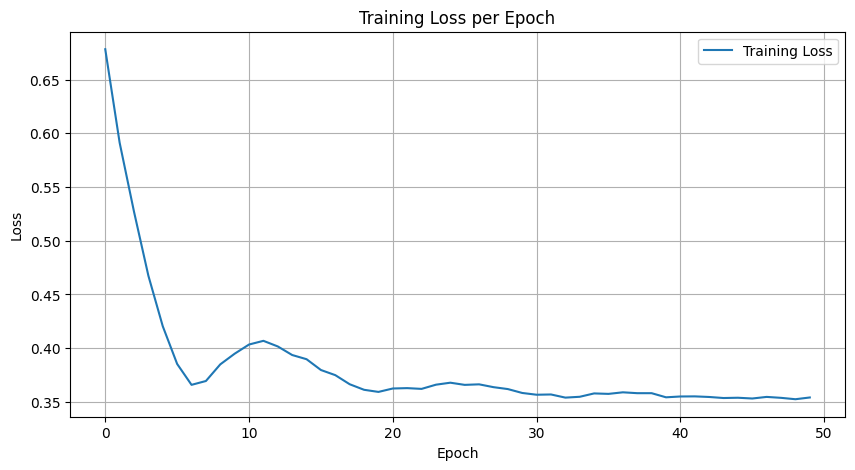

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values[:50], label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# def simple_subgraph_sampler(edge_index, num_nodes, sample_size=100):

#     # Randomly sample nodes
#     sampled_nodes = torch.randperm(num_nodes)[:sample_size]

#     # Find edges where both the source and target nodes are in the sampled set
#     mask = torch.isin(edge_index[0], sampled_nodes) & torch.isin(edge_index[1], sampled_nodes)
#     subgraph_edge_index = edge_index[:, mask]

#     # Adjust node indices in subgraph_edge_index to be local to the sampled set
#     node_mapping = {node.item(): i for i, node in enumerate(sampled_nodes)}
#     for i in range(subgraph_edge_index.size(1)):
#         subgraph_edge_index[0, i] = node_mapping[subgraph_edge_index[0, i].item()]
#         subgraph_edge_index[1, i] = node_mapping[subgraph_edge_index[1, i].item()]

#     return sampled_nodes, subgraph_edge_index



In [ ]:
def simple_subgraph_sampler(edge_index, eligible_nodes, sample_size=100):
    sampled_nodes = torch.tensor(np.random.choice(eligible_nodes, sample_size, replace=False))
    mask = torch.isin(edge_index[0], sampled_nodes) & torch.isin(edge_index[1], sampled_nodes)
    subgraph_edge_index = edge_index[:, mask]

    node_mapping = {node.item(): i for i, node in enumerate(sampled_nodes)}
    for i in range(subgraph_edge_index.size(1)):
        subgraph_edge_index[0, i] = node_mapping[subgraph_edge_index[0, i].item()]
        subgraph_edge_index[1, i] = node_mapping[subgraph_edge_index[1, i].item()]

    return sampled_nodes, subgraph_edge_index

def evaluate_on_subgraphs(model, edge_index, test_nodes, data, sample_size=100, num_samples=50, device='cpu'):
    model.to(device)
    model.eval()
    total_accuracy = 0
    all_preds = []
    all_labels = []

    for _ in range(num_samples):
        sampled_nodes, subgraph_edge_index = simple_subgraph_sampler(edge_index, test_nodes, sample_size)
        subgraph_x = data.x[sampled_nodes].to(device)
        subgraph_y = data.y[sampled_nodes].to(device)
        subgraph_edge_index = subgraph_edge_index.to(device)

        subgraph_out = model(subgraph_x, subgraph_edge_index)

        _, pred = subgraph_out.max(dim=1)
        correct = pred.eq(subgraph_y).sum().item()
        accuracy = correct / sample_size
        total_accuracy += accuracy
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(subgraph_y.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        mean_accuracy = total_accuracy / num_samples

    return mean_accuracy, cm

mean_accuracy,cm = evaluate_on_subgraphs(model, edge_index, test_nodes, data)
print(f"Mean accuracy over sampled subgraphs: {mean_accuracy}")
print("Confusion Matrix:\n", cm)

Mean accuracy over sampled subgraphs: 0.8786
Confusion Matrix:
 [[4393    0]
 [ 607    0]]


In [ ]:
sampled_nodes, subgraph_edge_index = simple_subgraph_sampler(edge_index, test_nodes, sample_size=1000)
subgraph_x = data.x[sampled_nodes].to('cpu')
subgraph_y = data.y[sampled_nodes].to('cpu')
subgraph_out = model(subgraph_x, subgraph_edge_index).detach()
_, pred = subgraph_out.max(dim=1)

print("Predictions:", pred[:10].numpy())
print("True labels:", subgraph_y[:10].numpy())


Predictions: [1 1 0 0 0 1 1 0 1 0]
True labels: [1 1 0 0 0 1 1 0 1 0]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyTorch Geometric data to NetworkX
G = to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Graph Visualization')
plt.show()

In [ ]:
states = ['State_AL', 'State_AZ', 'State_CA',
       'State_CO', 'State_CT', 'State_DC', 'State_FL', 'State_GA', 'State_IA',
       'State_IL', 'State_IN', 'State_KY', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MN', 'State_MO', 'State_NC', 'State_NE', 'State_NJ',
       'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_SC', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_WA', 'State_WI']
city_sizes = ['CitySize_big', 'CitySize_medium', 'CitySize_rural', 'CitySize_small']

In [ ]:
# Combine city size and state features for each sample
combined_features = df_filled[city_sizes + states].values
edges = []

for i in range(len(combined_features)):
    for j in range(i + 1, len(combined_features)):
        # Check if samples share at least one city size AND are in the same state
        if np.any(combined_features[i][:len(city_sizes)] & combined_features[j][:len(city_sizes)]) and np.any(combined_features[i][len(city_sizes):] & combined_features[j][len(city_sizes):]):
            edges.append((i, j))
            edges.append((j, i))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [ ]:
edge_index.shape

torch.Size([2, 29903274])

In [ ]:
labels = torch.tensor(df_filled['Remote'].values, dtype=torch.long)
data = Data(x=node_features, edge_index=edge_index, y=labels)

remote_status = node_features[:, 15]
minority_nodes = (remote_status == 1).nonzero().view(-1)
majority_nodes = (remote_status == 0).nonzero().view(-1)

downsampled_majority_nodes = majority_nodes[torch.randperm(len(majority_nodes))[:len(minority_nodes)]]

all_nodes = torch.cat([minority_nodes, downsampled_majority_nodes])
all_nodes = all_nodes[torch.randperm(len(all_nodes))]

train_nodes, test_nodes = train_test_split(all_nodes, test_size=0.2, stratify=remote_status[all_nodes], random_state=42)

In [ ]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 16)
        self.conv2 = SAGEConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_node_features=data.num_node_features, num_classes=2).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

In [ ]:
def sample_edges(edge_index, percentage=0.1):

    num_edges = edge_index.size(1)
    num_sampled = int(num_edges * percentage)

    sampled_indices = np.random.choice(num_edges, num_sampled, replace=False)
    sampled_indices = torch.from_numpy(sampled_indices).long()
    sampled_edge_index = edge_index[:, sampled_indices]

    return sampled_edge_index

for epoch in range(20):
    model.train()
    optimizer.zero_grad()

    sampled_edge_index = sample_edges(data.edge_index, percentage=0.01)

    out = model(data.x, sampled_edge_index)
    train_mask = torch.tensor(train_nodes, dtype=torch.long).to(device)  # Ensure train_mask is also on the correct device
    loss = criterion(out[train_mask], data.y[train_mask])

    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

<ipython-input-25-f4baed28cae7>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(train_nodes, dtype=torch.long).to(device)  # Ensure train_mask is also on the correct device


Epoch 1, Loss: 0.33486831188201904
Epoch 2, Loss: 0.3333370089530945
Epoch 3, Loss: 0.33109205961227417
Epoch 4, Loss: 0.3320654034614563
Epoch 5, Loss: 0.33249565958976746
Epoch 6, Loss: 0.33135712146759033
Epoch 7, Loss: 0.3294685184955597
Epoch 8, Loss: 0.33199000358581543
Epoch 9, Loss: 0.3312431573867798
Epoch 10, Loss: 0.325655460357666
Epoch 11, Loss: 0.3258312940597534
Epoch 12, Loss: 0.32766392827033997
Epoch 13, Loss: 0.32866665720939636
Epoch 14, Loss: 0.3309767246246338
Epoch 15, Loss: 0.3268328011035919
Epoch 16, Loss: 0.3287886083126068
Epoch 17, Loss: 0.3265976905822754
Epoch 18, Loss: 0.3276935815811157
Epoch 19, Loss: 0.32644325494766235
Epoch 20, Loss: 0.32836201786994934


In [ ]:
from sklearn.metrics import confusion_matrix
def simple_subgraph_sampler(edge_index, eligible_nodes, sample_size=100):
    # Sample nodes from the specified eligible nodes
    sampled_nodes = torch.tensor(np.random.choice(eligible_nodes, sample_size, replace=False))

    # Find edges where both the source and target nodes are in the sampled set
    mask = torch.isin(edge_index[0], sampled_nodes) & torch.isin(edge_index[1], sampled_nodes)
    subgraph_edge_index = edge_index[:, mask]

    # Adjust node indices in subgraph_edge_index to be local to the sampled set
    node_mapping = {node.item(): i for i, node in enumerate(sampled_nodes)}
    for i in range(subgraph_edge_index.size(1)):
        subgraph_edge_index[0, i] = node_mapping[subgraph_edge_index[0, i].item()]
        subgraph_edge_index[1, i] = node_mapping[subgraph_edge_index[1, i].item()]

    return sampled_nodes, subgraph_edge_index

def evaluate_on_subgraphs(model, edge_index, test_nodes, data, sample_size=100, num_samples=50, device='cpu'):
    model.to(device)
    model.eval()
    total_accuracy = 0
    all_preds = []
    all_labels = []

    for _ in range(num_samples):
        sampled_nodes, subgraph_edge_index = simple_subgraph_sampler(edge_index, test_nodes, sample_size)

        # Ensure tensors are on the correct device
        subgraph_x = data.x[sampled_nodes].to(device)
        subgraph_y = data.y[sampled_nodes].to(device)
        subgraph_edge_index = subgraph_edge_index.to(device)

        subgraph_out = model(subgraph_x, subgraph_edge_index)

        _, pred = subgraph_out.max(dim=1)
        correct = pred.eq(subgraph_y).sum().item()
        accuracy = correct / sample_size
        total_accuracy += accuracy
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(subgraph_y.cpu().numpy())

      # Compute the confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        mean_accuracy = total_accuracy / num_samples

    return mean_accuracy, cm


In [ ]:
mean_accuracy,cm = evaluate_on_subgraphs(model, edge_index, test_nodes, data)
print(f"Mean accuracy over sampled subgraphs: {mean_accuracy}")
print("Confusion Matrix:\n", cm)

Mean accuracy over sampled subgraphs: 0.8752000000000001
Confusion Matrix:
 [[4376    0]
 [ 624    0]]


In [ ]:
len(test_nodes)

1180

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


def simple_subgraph_sampler(edge_index, eligible_nodes, sample_size=100, device='cpu'):
    eligible_nodes = torch.tensor(eligible_nodes, device=device)

    sampled_nodes = torch.tensor(np.random.choice(eligible_nodes.cpu().numpy(), sample_size, replace=False), device=device)

    edge_index = edge_index.to(device)
    mask = torch.isin(edge_index[0], sampled_nodes) & torch.isin(edge_index[1], sampled_nodes)
    subgraph_edge_index = edge_index[:, mask]
    node_mapping = {node.item(): i for i, node in enumerate(sampled_nodes)}
    for i in range(subgraph_edge_index.size(1)):
        subgraph_edge_index[0, i] = node_mapping[subgraph_edge_index[0, i].item()]
        subgraph_edge_index[1, i] = node_mapping[subgraph_edge_index[1, i].item()]

    return sampled_nodes, subgraph_edge_index


def evaluate_on_subgraphs_with_confusion_matrix(model, edge_index, test_nodes, data, sample_size=100, num_samples=100, device='cpu'):
    model.to(device)
    model.eval()
    total_accuracy = 0
    all_preds = []
    all_labels = []

    for _ in range(num_samples):
        sampled_nodes, subgraph_edge_index = simple_subgraph_sampler(edge_index, test_nodes, sample_size)

        # Ensure tensors are on the correct device
        subgraph_x = data.x[sampled_nodes].to(device)
        subgraph_y = data.y[sampled_nodes].to(device)
        subgraph_edge_index = subgraph_edge_index.to(device)

        subgraph_out = model(subgraph_x, subgraph_edge_index)

        _, pred = subgraph_out.max(dim=1)
        correct = pred.eq(subgraph_y).sum().item()
        accuracy = correct / sample_size
        total_accuracy += accuracy

        # Collect predictions and true labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(subgraph_y.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    mean_accuracy = total_accuracy / num_samples

    return mean_accuracy, cm

# Evaluate the model and get both mean accuracy and confusion matrix
mean_accuracy, cm = evaluate_on_subgraphs_with_confusion_matrix(model, data.edge_index, test_nodes.numpy(), data, device=device)
print(f"Mean accuracy over sampled subgraphs: {mean_accuracy}")
print("Confusion Matrix:\n", cm)

Mean accuracy over sampled subgraphs: 0.8836000000000002
Confusion Matrix:
 [[8836    0]
 [1164    0]]
